In [1]:
import pandas as pd
from dataclasses import dataclass, asdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import helpers
import consts
from dto import TaskRawData

helpers.period_days = 7

In [2]:
collumn_names = TaskRawData.collumn()

In [3]:
df = pd.DataFrame.from_records([asdict(task) for task in helpers.generate_dataset()])
df

,process_name,task_name,owner,assigner,start_time,end_time,due_time,priority,var_count
0,Заказ товара,проверка склада,BOSS,Глеб,2021-09-02 16:33:21,2021-09-02 17:34:28.264858,2021-09-02 17:33:21,5,1
1,Заказ товара,проверка склада,BOSS,Глеб,2021-08-30 09:47:04,2021-08-30 10:46:41.765766,2021-08-30 10:47:04,5,1
2,Заказ товара,проверка склада,BOSS,Глеб,2021-09-02 07:07:52,2021-09-02 08:07:15.935962,2021-09-02 08:07:52,5,1
3,Заказ товара,проверка склада,BOSS,Соня,2021-09-02 16:18:24,2021-09-02 17:19:38.922143,2021-09-02 17:18:24,5,1
4,Заказ товара,проверка склада,BOSS,Глеб,2021-09-01 08:08:06,2021-09-01 09:06:51.887150,2021-09-01 09:08:06,5,1
...,...,...,...,...,...,...,...,...,...
1195,договор,оформление договора,BOSS,Соня,2021-09-01 18:14:21,2021-09-01 18:24:27.123609,2021-09-01 18:24:21,6,12
1196,договор,оформление договора,BOSS,Соня,2021-08-30 19:36:02,2021-08-30 19:46:08.319319,2021-08-30 19:46:02,6,12
1197,договор,оформление договора,BOSS,Миша,2021-09-02 19:32:26,2021-09-02 19:42:51.930825,2021-09-02 19:42:26,6,12
1198,договор,оформление договора,BOSS,Соня,2021-08-31 17:30:34,2021-08-31 17:40:37.729854,2021-08-31 17:40:34,6,12


In [4]:
df = helpers.date_preprocessing(df)

In [5]:
df['other_task_on_start'] = helpers.other_task_on_start(df)
df['elapsed'] = helpers.calculate_target_with_noise(df)



In [6]:
# кодируем категориальные признаки

for sign in consts.categorial_sign:
    tmp = pd.get_dummies(df[sign], prefix=sign)
    df = pd.concat([df,tmp], axis=1)


вроде более менее преобразованные данные получились,
необходимо убрать лишнее, это незакодированные категориальные признаки и возможно стоит убрать необработанное время
целевой признак затраченное время(elapsed)

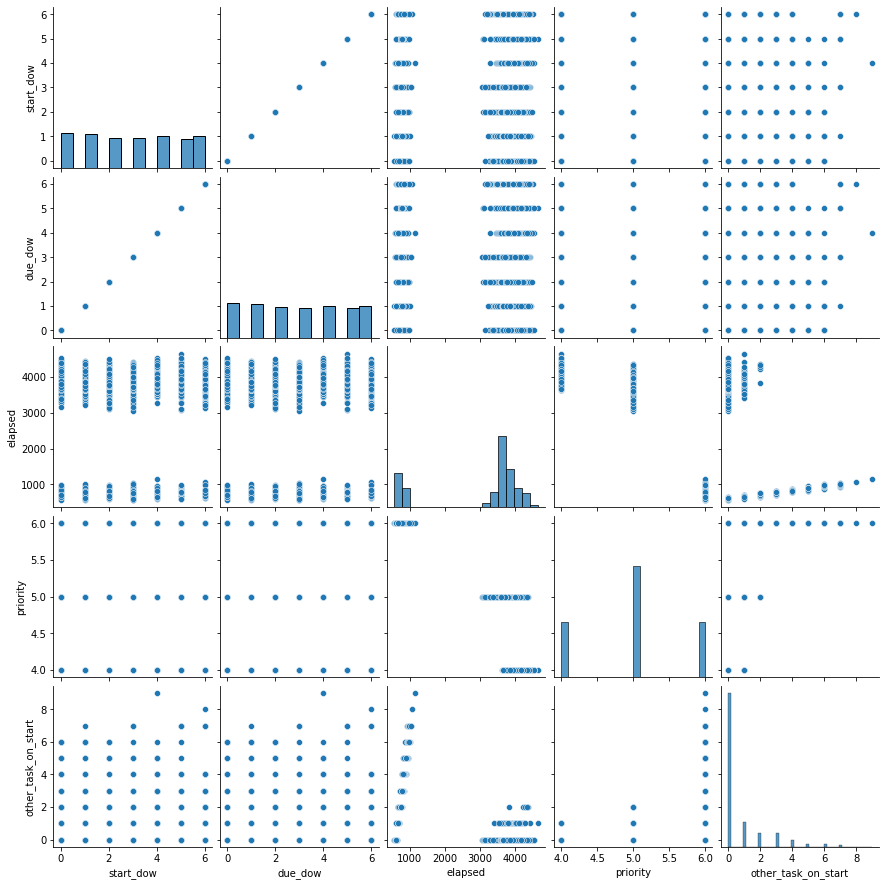

In [7]:

sns_plot = sns.pairplot(df[consts.pairplot_cols])

можно увидеть какие признаки точно влияют на целевой, а какие не очень

In [8]:
# "task_name_number", "assigner_number"
df = df.drop(columns=consts.need_drop)

In [9]:
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
# sol[:30]

т.к. корреляция признаков сильная, попробуем использовать Ridge  и Lasso регрессии

In [10]:

Y = df.elapsed.values
X = df.drop(columns=['elapsed'])


In [11]:
# X.head()
# X

In [12]:

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, ShuffleSplit

from models import scaler, ridge, lasso, skf, cv

print(ridge, lasso)


scaler.fit(X) 
# save scaler

X_scaled = scaler.transform(X)



RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])) LassoCV(max_iter=10000, random_state=42)


In [13]:
# check r2 score for comparison models
ridge_cvs = cross_val_score(ridge, X_scaled, Y, cv=cv)
lasso_cvs = cross_val_score(lasso, X_scaled, Y, cv=cv)
print(ridge_cvs)
print(lasso_cvs)
print(ridge_cvs.mean(), lasso_cvs.mean())

[0.98671476 0.98454929 0.98406423 0.98276475 0.98589484]
[0.98670723 0.98455137 0.98407593 0.98269431 0.98597115]
0.984797574193701 0.9847999984823825


 Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.
 
У нас на синтетических данных явно прослеживается зависимость от количвества других задач на время начала задачи и приоритета задачи, поэтому коэфициент детерминации высокий

In [14]:

split_indexes = skf.split(X_scaled, Y)
ridge = helpers.fit_model(ridge, X_scaled, Y, split_indexes)

split_indexes = skf.split(X_scaled, Y)
lasso = helpers.fit_model(lasso, X_scaled, Y, split_indexes)



/home/roman/projects/jupiter/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/roman/projects/jupiter/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


######
######
######
######
######
RidgeCV(alphas=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])):
score: [0.9842339568382835, 0.9854677672906648, 0.9853084590043214, 0.9855034436617309, 0.9843104533575807]
mse: [27535.56872371907, 25796.9138890159, 26312.629287934058, 25745.063545385237, 27844.2544546987]
mae [127.3715675783751, 123.04947856065895, 121.56627556746308, 117.45398680516597, 123.44179740541992]
me [483.7165290276416, 552.6601719683249, 530.5915851541295, 501.0002315846714, 534.5202213323105]
######
######
######
######
######
LassoCV(max_iter=10000, random_state=42):
score: [0.9841303794460887, 0.9857431547587673, 0.9851906190470152, 0.9851819485166735, 0.9838901239874918]
mse: [27716.46778455181, 25308.059427155375, 26523.68128804872, 26316.020726242357, 28590.213417202864]
mae [125.83340383496873, 120.78232470490592, 120.66088339676122, 116.85471501563167, 123.16423864292294]
me [506.933928871877, 569.0839408949637, 554.7481316153335, 538.481225

In [15]:
ridge.feature_names = list(X.columns.values)
lasso.feature_names = list(X.columns.values)

In [41]:
print( list(X.columns.values))
print( X.columns.values)
X

['priority', 'var_count', 'start_is_weekend', 'due_is_weekend', 'other_task_on_start', 'process_name_Заказ товара', 'process_name_договор', 'process_name_закупка', 'process_name_информирование', 'task_name_Оформить заявку', 'task_name_обзвон покупателей', 'task_name_оформление договора', 'task_name_проверка склада', 'owner_BOSS', 'assigner_Глеб', 'assigner_Миша', 'assigner_Соня', 'start_dow_0', 'start_dow_1', 'start_dow_2', 'start_dow_3', 'start_dow_4', 'start_dow_5', 'start_dow_6', 'due_dow_0', 'due_dow_1', 'due_dow_2', 'due_dow_3', 'due_dow_4', 'due_dow_5', 'due_dow_6']
['priority' 'var_count' 'start_is_weekend' 'due_is_weekend'
 'other_task_on_start' 'process_name_Заказ товара' 'process_name_договор'
 'process_name_закупка' 'process_name_информирование'
 'task_name_Оформить заявку' 'task_name_обзвон покупателей'
 'task_name_оформление договора' 'task_name_проверка склада' 'owner_BOSS'
 'assigner_Глеб' 'assigner_Миша' 'assigner_Соня' 'start_dow_0'
 'start_dow_1' 'start_dow_2' 'start_

,priority,var_count,start_is_weekend,due_is_weekend,other_task_on_start,process_name_Заказ товара,process_name_договор,process_name_закупка,process_name_информирование,task_name_Оформить заявку,...,start_dow_4,start_dow_5,start_dow_6,due_dow_0,due_dow_1,due_dow_2,due_dow_3,due_dow_4,due_dow_5,due_dow_6
0,5,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,5,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,5,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,5,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,6,12,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1196,6,12,0,0,6,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1197,6,12,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1198,6,12,0,0,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## SAVE models

In [18]:
from joblib import dump
dump(ridge, 'ridge.joblib') 
dump(lasso, 'lasso.joblib')

dump(scaler, 'scaler.joblib')
# model = joblib.load("lasso.joblib")


['scaler.joblib']

In [17]:
# from joblib import load
# import numpy as np
# model = load("lasso.joblib")
# model.predict(np.array([ 0.        , -1.16247639,  1.54901047,  1.54901047, -0.53935003,
#         1.73205081, -0.57735027, -0.57735027, -0.57735027, -0.57735027,
#        -0.57735027, -0.57735027,  1.73205081,  0.        , -0.69916647,
#        -0.68468113,  1.35531525, -0.41733475, -0.44989422, -0.37652323,
#        -0.42692623, -0.35305601,  2.29128785, -0.39364538, -0.41733475,
#        -0.44989422, -0.37652323, -0.42692623, -0.35305601,  2.29128785,
#        -0.39364538]).reshape(1,-1))

## predict example
берем задачу и преобразуем под вид, который принимает модель

In [2]:

task_example = TaskRawData(
    process_name="Заказ товара",
    task_name="проверка склада",
    owner="BOSS",
    assigner="Глеб",
    start_time=datetime(2021, 8, 31, 17, 51, 58),
    end_time=None,
    due_time=datetime(2021, 8, 31, 18, 51, 58),
    priority=5,
    var_count=1  
)
# TaskRawData(process_name='Заказ товара', task_name='проверка склада', owner='BOSS', assigner='Глеб', start_time=datetime.datetime(2021, 8, 31, 17, 51, 58), end_time=datetime.datetime(2021, 8, 31, 18, 51, 18, 302065), due_time=datetime.datetime(2021, 8, 31, 18, 51, 58), priority=50, var_count=1)

In [7]:
from joblib import load

model = load("ridge.joblib")
scaler = load("scaler.joblib")

assigner = "Миша"
task_example.assigner = assigner

input_other_task_on_start = active_task_count = 5

processing_val = helpers.processing_val([task_example], active_task_count, model, scaler)
predict = model.predict(processing_val)
print(predict)

['priority', 'var_count', 'start_is_weekend', 'due_is_weekend', 'other_task_on_start', 'process_name_Заказ товара', 'process_name_договор', 'process_name_закупка', 'process_name_информирование', 'task_name_Оформить заявку', 'task_name_обзвон покупателей', 'task_name_оформление договора', 'task_name_проверка склада', 'owner_BOSS', 'assigner_Глеб', 'assigner_Миша', 'assigner_Соня', 'start_dow_0', 'start_dow_1', 'start_dow_2', 'start_dow_3', 'start_dow_4', 'start_dow_5', 'start_dow_6', 'due_dow_0', 'due_dow_1', 'due_dow_2', 'due_dow_3', 'due_dow_4', 'due_dow_5', 'due_dow_6']
[4000.72661965]


In [52]:


# input_df = pd.DataFrame.from_records([asdict(task_example)])

In [53]:
input_df = helpers.date_preprocessing(input_df)

In [54]:
input_df['other_task_on_start'] = input_other_task_on_start

In [55]:
for sign in consts.categorial_sign:
    tmp = pd.get_dummies(input_df[sign], prefix=sign)
    input_df = pd.concat([input_df,tmp], axis=1)
input_df

,process_name,task_name,owner,assigner,start_time,end_time,due_time,priority,var_count,start_dow,start_is_weekend,due_dow,due_is_weekend,other_task_on_start,process_name_Заказ товара,task_name_проверка склада,owner_BOSS,assigner_Миша,start_dow_1,due_dow_1
0,Заказ товара,проверка склада,BOSS,Миша,2021-08-31 17:51:58,None,2021-08-31 18:51:58,5,1,1,0,1,0,5,1,1,1,1,1,1


In [56]:
input_df = input_df.drop(columns=consts.need_drop)

In [57]:
from joblib import load

model = load("ridge.joblib")
fscaler = load("scaler.joblib")


In [58]:
input_vals = []
print(model.feature_names)
for i, col in enumerate(model.feature_names):
    if col not in input_df:
        input_vals.append(0)
    else:
        input_vals.append(input_df[col].values[0])

print("!,", input_vals)

input_vals = np.array(input_vals).reshape(1, -1)

input_vals_scaled = scaler.transform(input_vals)
# print(X.iloc[0])
print(input_vals)
print(X.iloc[0].values.reshape(1,-1))
test = scaler.transform(X.iloc[0].values.reshape(1,-1))
print(test)
print(input_vals_scaled)



['priority', 'var_count', 'start_is_weekend', 'due_is_weekend', 'other_task_on_start', 'process_name_Заказ товара', 'process_name_договор', 'process_name_закупка', 'process_name_информирование', 'task_name_Оформить заявку', 'task_name_обзвон покупателей', 'task_name_оформление договора', 'task_name_проверка склада', 'owner_BOSS', 'assigner_Глеб', 'assigner_Миша', 'assigner_Соня', 'start_dow_0', 'start_dow_1', 'start_dow_2', 'start_dow_3', 'start_dow_4', 'start_dow_5', 'start_dow_6', 'due_dow_0', 'due_dow_1', 'due_dow_2', 'due_dow_3', 'due_dow_4', 'due_dow_5', 'due_dow_6']
!, [5, 1, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[[5 1 0 0 5 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]]
[[5 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]]
[[ 0.         -1.16247639 -0.61716901 -0.61716901 -0.52616542  1.73205081
  -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027 -0.57735027
   1.73205081  0.          1.42220604 -0.692

In [59]:
print(model.predict(input_vals_scaled))

[4000.72661965]


In [60]:
X_scaled[1]
input_vals_scaled

array([[ 0.        , -1.16247639, -0.61716901, -0.61716901,  2.87210426,
         1.73205081, -0.57735027, -0.57735027, -0.57735027, -0.57735027,
        -0.57735027, -0.57735027,  1.73205081,  0.        , -0.703133  ,
         1.44389505, -0.7257531 , -0.43101131,  2.36503839, -0.3992747 ,
        -0.39223227, -0.41181385, -0.39081678, -0.40904178, -0.43101131,
         2.36503839, -0.3992747 , -0.39223227, -0.41181385, -0.39081678,
        -0.40904178]])